
# **PyTorch - Facial Similarity with Siamese Networks in Pytorch**

---


In this lesson, we will implement **Facial Similarity with Siamese Networks in Pytorch** using PyTorch.

The goal is to teach a siamese network to be able to distinguish pairs of images. The outline of this lesson is below:

1. Load our modules, data and define some utlity functions
2. Setup our Data Processing - Create our Image Pairs
3. Building our Siamese Network
4. Start Training
5. View our Test Results

**Credits**:

You can read the accompanying article at https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e

Source - https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch

Note:
Any dataset can be used. Each class must be in its own folder. This is the same structure that PyTorch's own image folder dataset uses.

## **1. Load our modules, data and define some utlity functions**

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

### **Create a simple image show and plotting function**

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### **Download our dataset - The AT&T Faces Dataset**
Source - https://www.kaggle.com/kasikrit/att-database-of-faces

In [3]:
# Download and unzip our data
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/face_data.zip
!unzip -q face_data.zip

--2023-06-22 11:58:01--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/face_data.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.150.190
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.150.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3821906 (3.6M) [application/zip]
Saving to: ‘face_data.zip’

face_data.zip       100%[===================>]   3.64M  5.39MB/s    in 0.7s    

2023-06-22 11:58:02 (5.39 MB/s) - ‘face_data.zip’ saved [3821906/3821906]



### **Create a class that stores our parameters**

In [4]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## **2. Setup our Data Processing - Create our Image Pairs**

In [5]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

### **Set out image Folders**

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

### **Create our transformers**

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                                                      should_invert=False)

### **Create our Data Loader and View some sample Images**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


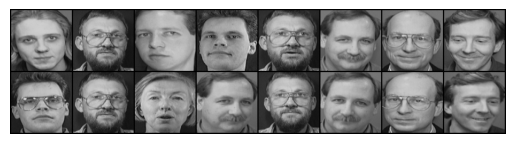

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## **3. Building our Siamese Network**

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## **Define our Contrastive Loss Function**

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### **Make our Training Data Loader**

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### **Define our Loss and Optimizer before training**

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

## **4. Start Training**

Epoch number 0
 Current loss 1.9156818389892578

Epoch number 1
 Current loss 1.4702198505401611

Epoch number 2
 Current loss 1.6983528137207031

Epoch number 3
 Current loss 1.7989895343780518

Epoch number 4
 Current loss 0.7013106346130371

Epoch number 5
 Current loss 0.48136448860168457

Epoch number 6
 Current loss 0.46047407388687134

Epoch number 7
 Current loss 0.42349791526794434

Epoch number 8
 Current loss 0.2584764361381531

Epoch number 9
 Current loss 0.32863759994506836

Epoch number 10
 Current loss 0.26385703682899475

Epoch number 11
 Current loss 0.15936897695064545

Epoch number 12
 Current loss 0.1577555239200592

Epoch number 13
 Current loss 0.09785252064466476

Epoch number 14
 Current loss 0.12724639475345612

Epoch number 15
 Current loss 0.10726747661828995

Epoch number 16
 Current loss 0.08468867093324661

Epoch number 17
 Current loss 0.11976616084575653

Epoch number 18
 Current loss 0.09780141711235046

Epoch number 19
 Current loss 0.0549245551228523

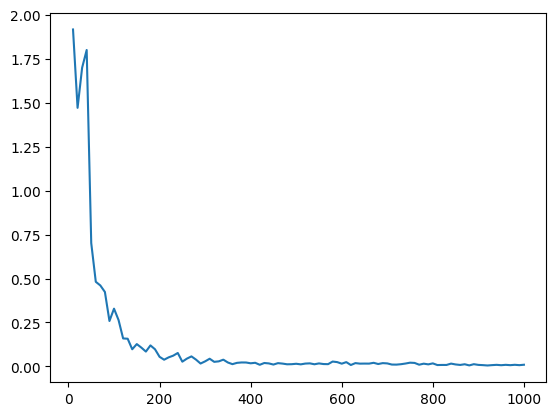

In [14]:
counter = []
loss_history = []
iteration_number= 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter,loss_history)

## **5. View our Test Results**

The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


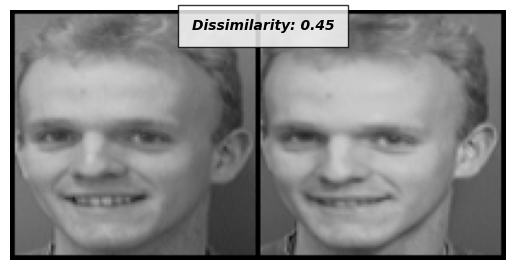

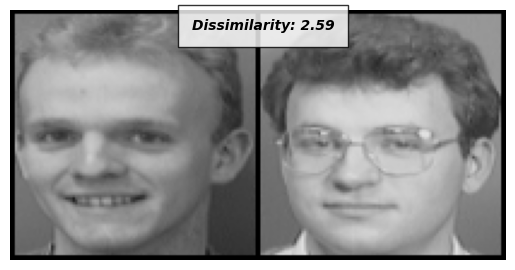

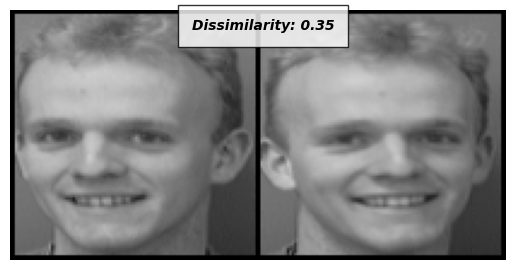

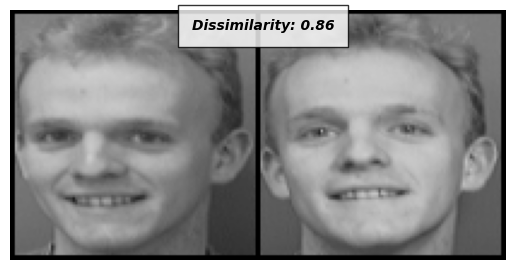

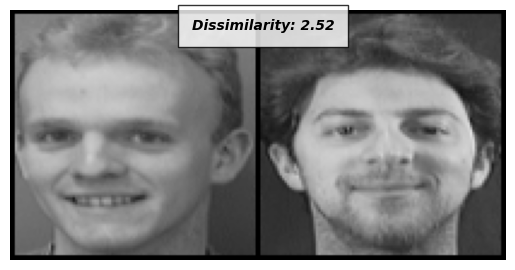

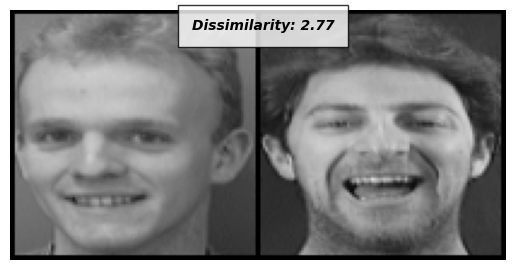

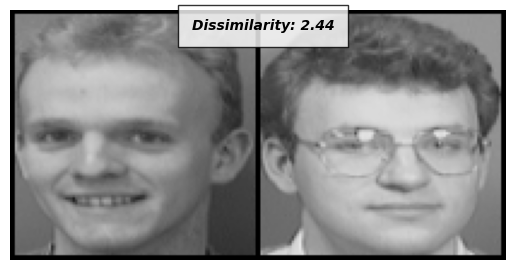

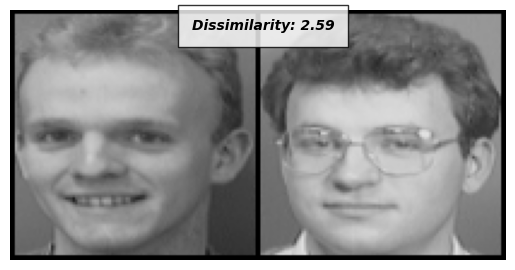

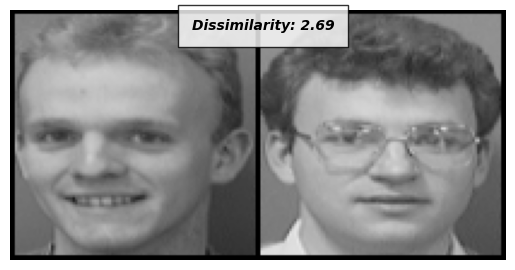

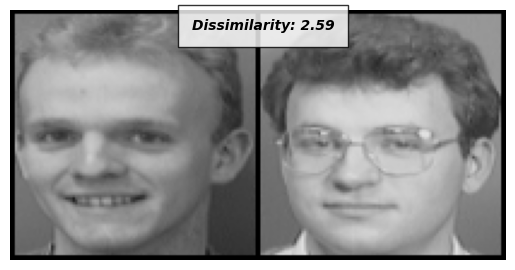

In [15]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))